# III. Example -- Flow over a square cylinder

In [5]:
# Boilerplate import statements
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from scipy.integrate import simps

## Parameters
This code defines the parameters in the CFD model. You may need to change these.

In [43]:
Re = 40 # Reynolds number

# time stepping
dt = 2e-4 # time step size
Nt = 5001 # number of time steps
Np = int(5e3) # max no. of iterations for the pressure poisson equation

# grid parameters
Lx = 5.5 # box size in the x-direction
Ly = 1 # box size in the y-direction
Nx = int(64*Lx)+1 # number of grid points in the x-direction
Ny = int(64*Ly)+1 # number of grid points in the y-direction

# box coordinates
box_width = 0.2 # height & width of the square cylinder
box_height = 0.2 # height & width of the square cylinder
box_x = 2 # x-location of the center of the cylinder
box_y = 0.5 # y-location of the center of the cylinder

## Set up the grid
You shouldn't change this unless you know what you are doing

In [44]:
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
dx = x[1]-x[0]
dy = y[1]-y[0]
X, Y = np.meshgrid(x, y, indexing='ij')
t = np.zeros(Nt)

box_L = int( (box_x - box_width/2)/dx )
box_R = int( (box_x + box_width/2)/dx )
box_B = int( (box_y - box_height/2)/dy )
box_T = int( (box_y + box_height/2)/dy )

# These "slices" allow us to access the elements of
# arrays without having to do lots of extra loops
i = slice(1, Nx-1)
im1 = slice(0, Nx-2) # im1 == i-1
ip1 = slice(2, Nx) # ip1 == i+1
j = slice(1, Ny-1)
jm1 = slice(0, Ny-2) 
jp1 = slice(2, Ny)

print('---------------------')
print('For your information:')
print('---------------------')
print('Total number of grid points', \
      '(Nx = %d x Ny = %d): Ntot = %d '%(Nx, Ny, Nx*Ny))
print('Grid spacing: dx=%0.5f, dy=%0.5f'%(dx, dy))
print('Box size in grid points: (%0.1f x %0.1f)'\
      %(box_width/dx, box_height/dy))
print('Box center grid point: (%0.1f, %0.1f)'%(box_x/dx, box_y/dy))
print('Lower left grid point of box: (%0.1f, %0.1f)'%(box_L, box_B))
print('Upper right grid point of box: (%0.1f, %0.1f)'%(box_R, box_T))

---------------------
For your information:
---------------------
Total number of grid points (Nx = 1079 x Ny = 197): Ntot = 212563 
Grid spacing: dx=0.00510, dy=0.00510
Box size in grid points: (39.2 x 39.2)
Box center grid point: (392.0, 98.0)
Lower left grid point of box: (372.0, 78.0)
Upper right grid point of box: (411.0, 117.0)


## Set the initial condition
Again, this probably shouldn't change unless you know what you are doing.

In [45]:
P = np.zeros((Nx, Ny))
vy = np.zeros((Nx, Ny))

# 
U=1 
# create vx, and set boundaries to zero
vx = np.zeros((Nx, Ny))
# all internal nodes have a parabolic flow profile in the channel
vx[:,j] = 4*U*Y[:,j]*(Ly-Y[:,j])/Ly**2
# set no slip & no penetration conditions on the box
vx[box_L:box_R, box_B:box_T] = 0

## CFD Solver main loop

* The outer loop (index = $n$) loops over time steps.
* The inner loop (index = $m$) solves the pressure poisson equation.
* The Navier--Stokes equation is then updated after the PPE is solved.

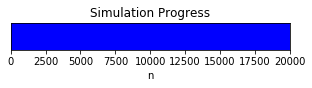

In [46]:
# some useful arrays to hold intermediate data
b = np.zeros((Nx, Ny))
vx_n = np.zeros((Nx, Ny))
vy_n = np.zeros((Nx, Ny))
vx_diff = np.zeros(Nt)
vy_diff = np.zeros(Nt)

# figure for progress bar
fig1,ax1=plt.subplots(1,1, figsize=(5,0.5))
ax1.set_xlim(0,Nt-1)
ax1.set_ylim(0,1)
ax1.set_xlabel('n')
ax1.get_yaxis().set_visible(False)
ax1.set_title('Simulation Progress')

for n in range(Nt):

    # ---------------------------
    # (a) Get everything we need
    # ---------------------------
    
    # make a copy of vx, vy
    vx_n = np.copy(vx)
    vy_n = np.copy(vy)
    
    # vx-derivatives (finite difference formulas)
    # (first derivatives -- upwind)
    dvx_dx = (vx_n[i, j] - vx_n[im1, j])/dx
    dvx_dy = (vx_n[i, j] - vx_n[i, jm1])/dy
    # (first derivatives -- centered)
    dvx_dx_c = (vx_n[ip1, j] - vx_n[im1, j])/(2*dx)
    dvx_dy_c = (vx_n[i, jp1] - vx_n[i, jm1])/(2*dy)
    # (second derivatives)
    d2vx_dx2 = (vx_n[ip1, j] - 2*vx_n[i, j] + vx_n[im1, j])/(dx*dx)
    d2vx_dy2 = (vx_n[i, jp1] - 2*vx_n[i, j] + vx_n[i, jm1])/(dy*dy)

    # vy-derivatives (finite difference formulas)
    # (first derivatives -- upwind)
    dvy_dx = (vy_n[i, j] - vy_n[im1, j])/dx
    dvy_dy = (vy_n[i, j] - vy_n[i, jm1])/dy
    # (first derivatives -- centered)
    dvy_dx_c = (vy_n[ip1, j] - vy_n[im1, j])/(2*dx)
    dvy_dy_c = (vy_n[i, jp1] - vy_n[i, jm1])/(2*dy)
    # (second derivatives)
    d2vy_dx2 = (vy_n[ip1, j] - 2*vy_n[i, j] + vy_n[im1, j])/(dx*dx)
    d2vy_dy2 = (vy_n[i, jp1] - 2*vy_n[i, j] + vy_n[i, jm1])/(dy*dy)

    # -----------------------------------
    # (b) Solve pressure poisson equation 
    #    (This should enforce continuity)
    # -----------------------------------  
    
    # This is the right hand side of the pressure poisson equation
    bij = (dvx_dx_c + dvy_dy_c)/dt \
          - dvx_dx_c**2 - 2*dvx_dy_c*dvy_dx_c - dvy_dy_c**2

    # Inner loop to solve the pressure poisson equation
    m = 0
    err = 1
    while (err > 1e-3 and m <= Np): 
    # Iterate until P converges or we take
    # too long, i.e. m gets bigger than Np.

        Pm = np.copy(P)
        P[i,j] = (   (Pm[ip1,j]+Pm[im1,j])*dy**2 
                   + (Pm[i,jp1]+Pm[i,jm1])*dx**2 
                   - bij*dx**2*dy**2 
                 )/(2*(dx**2 + dy**2))
    
        # Pressure Boundary Conditions
        # Let P @ x=0 float
        P[Nx-1,:] = 0           # x=Lx: P=0
        P[:,0] = P[:,1]         # y=0 : dP/dy=0
        P[:, Ny-1] = P[:, Ny-2] # y=Ly: dP/dy=0

        # Check if we have converged
        err = np.linalg.norm(P - Pm)/max(1e-8, np.linalg.norm(Pm))
        m+=1
    
    # ------------------------------------------------------
    # (c) Update the velocities using the momentum equation
    # ------------------------------------------------------

    # Get the pressure derivatives using a finite diff. formula
    dP_dx = (P[ip1, j] - P[im1, j])/(2*dx)
    dP_dy = (P[i, jp1] - P[i, jm1])/(2*dy)

    # Solve N-S equation
    vx[i, j] = vx_n[i,j] + dt*( \
        -vx_n[i,j]*dvx_dx - vy_n[i,j]*dvx_dy \
        - dP_dx + (1./Re)*(d2vx_dx2 + d2vx_dy2) )
    vy[i, j] = vy_n[i,j] + dt*( \
        -vx_n[i,j]*dvy_dx - vy_n[i,j]*dvy_dy 
        - dP_dy + (1./Re)*(d2vy_dx2 + d2vy_dy2) )

    # Velocity Boundary Conditions
    vx[i, 0] = 0     # y=0 : vx=0 (no slip)
    vy[i, 0] = 0     # y=0 : vy=0 (no penetration)
    vx[i, Ny-1] = 0  # y=Ly: vx=0 (no slip)
    vy[i, Ny-1] = 0  # y=Ly: vy=0 (no penetration)
    vx[0, :] = 4*U*y*(Ly-y)/Ly**2 # x=0: vx inflow BC (parabolic)
    vy[0, j] = 0                  # x=0: vy=0
    # let vx, vy @ x=Lx float (Pressure is set to 0)

    # box BCs
    vx[box_L:box_R, box_B:box_T] = 0 # no slip/no penetration
    vy[box_L:box_R, box_B:box_T] = 0 # no slip/no penetration

    # (if steady state) check convergence
    t[n] = n*dt
    vx_diff[n] = np.linalg.norm(vx - vx_n)/max(1e-8, np.linalg.norm(vx_n))
    vy_diff[n] = np.linalg.norm(vy - vy_n)/max(1e-8, np.linalg.norm(vy_n))

    # Plot our progress
    if ( n%20 == 0 or n==Nt):
        ax1.barh(0.5, width=Nt-1, height=1, color='gray')
        ax1.barh(0.5, width=n, height=1, color='blue', zorder=2)        
        display.display(fig1)
        display.clear_output(wait=True)
        
        if (vx_diff[n] > 1e10 or np.isnan(vx_diff[n])):
            print('Error: Calculation has diverged.')
            break

## Make plots to look at the solution

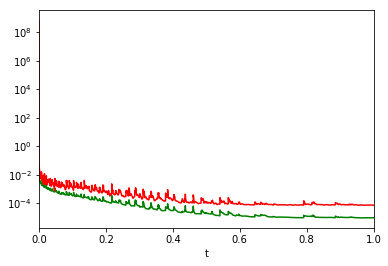

In [47]:
# Plot convergence to check if steady state
fig2,ax2=plt.subplots(1,1)
ax2.set_xlim(0, Nt*dt)
ax2.set_yscale('log')
ax2.set_xlabel('t')
ax2.plot(t[0:n], vx_diff[0:n], 'g-');
ax2.plot(t[0:n], vy_diff[0:n], 'r-');

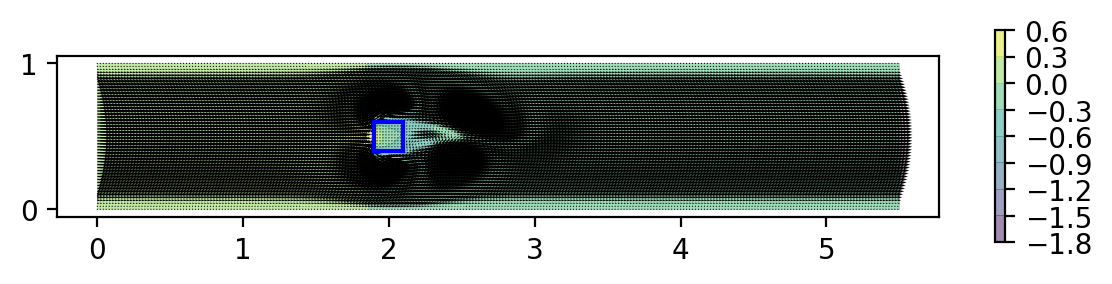

In [48]:
# Make an arrow plot
# * Velocities are the arrows
# * Colors are contours of the pressure

xres = 4 # resolution, so not too many arrows
yres = 4 # resolution, so not too many arrows
plt.figure(figsize=(6,1.5), dpi=200)
p1 = plt.contourf(x, y, P.T, alpha=0.5)
plt.colorbar(p1)
plt.quiver(x[::xres], y[::yres], vx[::xres,::yres].T, vy[::xres,::yres].T, \
           scale=60, width=0.0015, headwidth=2.5, headlength=4)
plt.plot([box_L*dx, box_R*dx], [box_T*dy, box_T*dy], 'b-', linewidth=1.5)
plt.plot([box_L*dx, box_R*dx], [box_B*dy, box_B*dy], 'b-', linewidth=1.5)
plt.plot([box_L*dx, box_L*dx], [box_B*dy, box_T*dy], 'b-', linewidth=1.5)
plt.plot([box_R*dx, box_R*dx], [box_B*dy, box_T*dy], 'b-', linewidth=1.5)

plt.xlim([-0.05*Lx, 1.05*Lx])
plt.ylim([-0.05*Ly, 1.05*Ly])
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

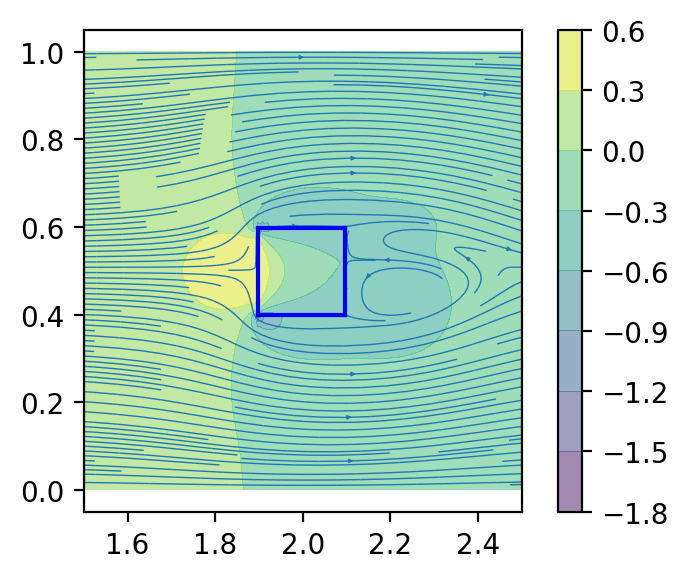

In [49]:
# Make a zoomed-in plot of the streamlines

plt.figure(figsize=(4,3), dpi=200)
p1 = plt.contourf(x, y, P.T, alpha=0.5)
plt.colorbar(p1)
plt.streamplot(x, y, vx.T, vy.T, density=3, linewidth=0.5, arrowsize=0.3)
plt.plot([box_L*dx, box_R*dx], [box_T*dy, box_T*dy], 'b-', linewidth=1.5)
plt.plot([box_L*dx, box_R*dx], [box_B*dy, box_B*dy], 'b-', linewidth=1.5)
plt.plot([box_L*dx, box_L*dx], [box_B*dy, box_T*dy], 'b-', linewidth=1.5)
plt.plot([box_R*dx, box_R*dx], [box_B*dy, box_T*dy], 'b-', linewidth=1.5)

plt.xlim([box_x-2.5*box_width, box_x+2.5*box_width])
plt.ylim([-0.05*Ly, 1.05*Ly])
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

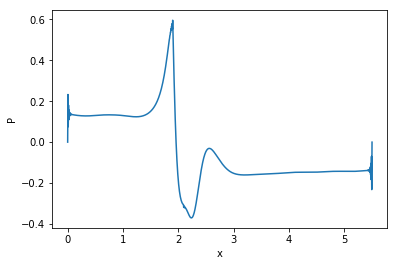

In [50]:
# Plot the pressure along the centerline

plt.figure()
plt.plot(x, P[:, int(Ny/2)])
plt.xlabel('x')
plt.ylabel('P');

## Calculate the drag force

In [51]:
## Calculate the tau's

# Get the relevant derivatives
dvx_dx = (vx[ip1, j] - vx[im1, j])/(2*dx)
dvx_dy = (vx[i, jp1] - vx[i, jm1])/(2*dy)
dvy_dx = (vy[ip1, j] - vy[im1, j])/(2*dx)

# In the dimensionless equations we are using 
# we get a 1/Re instead of a mu
tau_xx = 2./Re * dvx_dx 
tau_xy = 1./Re * (dvx_dy + dvy_dx)


In [52]:
# -- Left face --
# pick out the pressure, tau_xx and y along the box left face
P_L = P[box_L, box_B:box_T]
tau_xx_L = tau_xx[box_L, box_B:box_T]
y_L = Y[box_L, box_B:box_T]

Fx_L = simps(P_L-tau_xx_L, y_L) # integrate over surface
CD_L = Fx_L/(y_L[-1]-y_L[0])    # divide by length to get FD/A_perp
print("Left: Fx = ", Fx_L)

# -- Right face --
# pick out the pressure, tau_xx and y along the box right face
P_R = P[box_R, box_B:box_T]
tau_xx_R = tau_xx[box_R, box_B:box_T]
y_R = Y[box_R, box_B:box_T]

Fx_R = simps(-P_R+tau_xx_R, y_R)# integrate over suface
CD_R = Fx_R/(y_R[-1]-y_R[0])    # divide by length to get FD/A_perp
print("Right: Fx = ", Fx_R)

# -- Bottom face --
# pick out tau_xy and x along the bottom face of the box
tau_xy_B = tau_xy[box_L:box_R, box_B]
x_B = X[box_L:box_R, box_B]

Fx_B = simps(-tau_xy_B, x_B)    # integrate over the surface
CD_B = Fx_B/(x_B[-1]-x_B[0])    # divide by length to get FD/A_pll
print("Bottom: Fx = ", Fx_B)

# -- Top face --
# pick out tau_xy and x along the bottom face of the box
tau_xy_T = tau_xy[box_L:box_R, box_T]
x_T = X[box_L:box_R, box_T]

Fx_T = simps(tau_xy_T, x_T)
CD_T = Fx_T/(x_T[-1]-x_T[0])    # divide by length to get FD/A_pll
print("Top: Fx = ", Fx_T)

# -- Get the total drag --
F_D = Fx_L + Fx_R + Fx_B + Fx_T
C_D = CD_L + CD_R + CD_B + CD_T

print('')
print('Drag force, F_D = ', F_D, '(units of rho*U**2)')
print('Drag coefficient of square cylinder (CFD)), C_D = %0.4f'%C_D)

# p. 58 in Deen, valid for Re < 2e5
CD_book = 1.18 + 6.8/Re**0.89 + 1.96/Re**0.5 - (4e-4/(1+3.64e-7*Re**2))
print('Drag coefficient of a circular cylinder (Deen),'\
      ' C_D = %0.4f'%CD_book)


Left: Fx =  0.0882155456692
Right: Fx =  0.0638318348951
Bottom: Fx =  5.80912494452e-05
Top: Fx =  0.00480448416147

Drag force, F_D =  0.156909955975 (units of rho*U**2)
Drag coefficient of square cylinder (CFD)), C_D = 0.8093
Drag coefficient of a circular cylinder (Deen), C_D = 1.2942


This drag coefficient is in the right ballpark, but it is probably not exactly right. It is difficult to get an accurate $C_{D}$, and this is not the most accurate CFD code.

In [53]:
## Write solution to file, so we can save it
                                         
f1 = open('CFD_Drag_2D_Rectangular_Cylinder_Re=%d.dat'%Re, 'wb') 
f1.write(b'#########################################\n')
f1.write(b'# CFD Solution: 2D Rectangular Cylinder #\n')
f1.write(b'#########################################\n')
f1.write(b'# Re = %e\n'%Re)
f1.write(b'# Lx = %d, Ly = %d\n'%(Lx, Ly))
f1.write(b'# Nx = %d, Ny = %d\n'%(Nx, Ny))
f1.write(b'# Nt = %d, dt = %e, Np = %d\n'%(Nt, dt, Np))
f1.write(b'# box_width = %f, box_height = %f\n'%(box_width, box_height))
f1.write(b'# box_x = %f, box_y = %f\n'%(box_x, box_y))
f1.write(b'# Drag Force = %f, Drag Coefficient = %f\n'%(F_D, C_D))
f1.write(b'# columns: X, Y, vx, vy, P\n')
np.savetxt(f1, np.array([X.flatten(), Y.flatten(), vx.flatten(), vy.flatten(), P.flatten()]).T, fmt='%22.15e')
f1.close()